In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io as sio

import fitting_functions

import scipy.optimize
import tqdm.notebook

In [3]:
traces = ['090711e_0006', '090811c_0002', '090811d_0002', '090811d_0004','091111a_0001',
          '091111a_0003','091111c_0003','091211a_0002','091211a_0005']

In [4]:
data_folder = '../data/active/'

To perform our analysis of the persistence of the neural drive required to generate observed fixations given distributed or fast plants, we extracted only the post-saccadic fixation of the eye position data from the active state recordings. The fixation was defined to start at the point that eye position was maximal.

In [6]:
tranges_fix = [[],]*len(traces)
pes_fix = [[],]*len(traces)


for i in range(len(traces)):
    full_trange, full_data, pe_start_index, displacement_index, release_index, step_pos = fitting_functions.importActiveData(data_folder + 'raw/'+traces[i])
    
    new_start_index = np.argmax(full_data[:displacement_index])
    
    tranges_fix[i] = full_trange[new_start_index:displacement_index] - full_trange[new_start_index]
    pes_fix[i] = full_data[new_start_index:displacement_index]/full_data[new_start_index]

# Plot all responses individually

The averaged response does not show a strong peak in the post-displacement eye position, so we looked at the full time lengths for each response individually to look for the existence of the artifact peak.

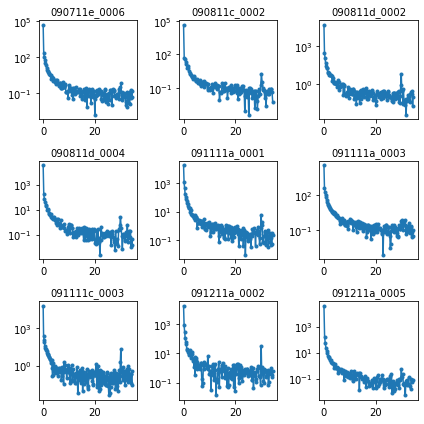

In [7]:
plt.figure(figsize=((6, 6)))
for i in range(len(traces)):
    fft_fix = np.fft.fft(pes_fix[i])
   
    fft_freq_fix = np.fft.fftfreq(len(tranges_fix[i]), tranges_fix[i][1])

    plt.subplot(3,3,i+1)
    plt.yscale('log')
    plt.plot(fft_freq_fix[:len(fft_freq_fix)//2], np.abs(fft_fix[:len(fft_freq_fix)//2])**2,'.-')
    plt.title(traces[i], fontsize=10)
    
plt.tight_layout()

# Fix individual responses 

Because of the frequency binning of each response, the widths of the artifact peaks differ across responses. Here, we removed the peaks by manually looking at the width of the peak for each individual response.

In [60]:
i = 8

full_trange, full_data, pe_start_index, displacement_index, release_index, step_pos = fitting_functions.importActiveData(data_folder + 'raw/'+traces[i]+'.mat')

new_start_index = np.argmax(full_data[:displacement_index])
trange_fix = full_trange[new_start_index:displacement_index] - full_trange[new_start_index]
pe_fix = full_data[new_start_index:displacement_index]/full_data[new_start_index]

fft_fix = np.fft.fft(pe_fix)
fft_fix_new = np.copy(fft_fix)


fft_freq_fix = np.fft.fftfreq(len(trange_fix), trange_fix[1])


fix_max = len(fft_fix)//2-50 + np.argmax(np.abs(fft_fix[len(fft_fix)//2-50:len(fft_fix)//2])**2)

mean_window_size = 5 # half-width of window over which to calculate mean (not including window center)

fix_window_size = 1 # half-width of window over which to replace FFT gain with mean


fft_fix_new[fix_max-fix_window_size:fix_max+fix_window_size+1] *= np.mean(np.abs(np.concatenate((fft_fix[fix_max-fix_window_size-mean_window_size:fix_max-fix_window_size], 
                                                                                       fft_fix[fix_max+fix_window_size+1:fix_max+fix_window_size+mean_window_size+1]))))/np.abs(fft_fix[fix_max-fix_window_size:fix_max+fix_window_size+1])

fft_fix_new[-fix_max-fix_window_size:-fix_max+fix_window_size+1] *= np.mean(np.abs(np.concatenate((fft_fix[-fix_max-fix_window_size-mean_window_size:-fix_max-fix_window_size+1], 
                                                                                       fft_fix[-fix_max+fix_window_size:-fix_max+fix_window_size+mean_window_size+1]))))/np.abs(fft_fix[-fix_max-fix_window_size:-fix_max+fix_window_size+1])


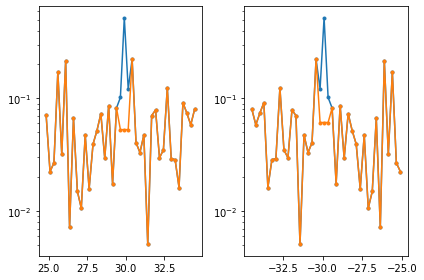

In [61]:
plot_window_size = 20

plt.subplot(1,2,1)
plt.yscale('log')
plt.plot(fft_freq_fix[fix_max-plot_window_size:np.minimum(fix_max+plot_window_size+1, len(fft_freq_fix)//2)],
         np.abs(fft_fix[fix_max-plot_window_size:np.minimum(fix_max+plot_window_size+1, len(fft_freq_fix)//2)])**2, '.-')
plt.plot(fft_freq_fix[fix_max-plot_window_size:np.minimum(fix_max+plot_window_size+1, len(fft_freq_fix)//2)],
         np.abs(fft_fix_new[fix_max-plot_window_size:np.minimum(fix_max+plot_window_size+1, len(fft_freq_fix)//2)])**2, '.-')


plt.subplot(1,2,2)
plt.yscale('log')
plt.plot(fft_freq_fix[np.maximum(-len(fft_freq_fix)//2+1, -(fix_max+plot_window_size+1)):-(fix_max-plot_window_size)],
         np.abs(fft_fix[np.maximum(-len(fft_freq_fix)//2+1, -(fix_max+plot_window_size+1)):-(fix_max-plot_window_size)])**2, '.-')
plt.plot(fft_freq_fix[np.maximum(-len(fft_freq_fix)//2+1, -(fix_max+plot_window_size+1)):-(fix_max-plot_window_size)],
         np.abs(fft_fix_new[np.maximum(-len(fft_freq_fix)//2+1, -(fix_max+plot_window_size+1)):-(fix_max-plot_window_size)])**2, '.-')

plt.tight_layout()


In [62]:
pe_fix_fixed = np.real(np.fft.ifft(fft_fix_new))

sio.savemat(data_folder + 'fixed/saccades/'+traces[i]+'.mat',\
            {'trange':trange_fix, 'data':pe_fix_fixed}, appendmat=False) 